# Chapter-4: Create netCDF for time series data

"Time Series" are data that are taken over a period of time for a single or multiple stations. Stations have unique identifiers. NetCDF files containing time series require the attribute `featureType = timeSeries` as a global attribute. As announced in [Chapter 2](PART2_Introduction_CF_Conventions.ipynb), we will walk you through the procedure of creating a netCDF file for various types of time series data as suggested by the CF Conventions in this chapter.

The CF Conventions introduced the following representations for time series:

* Single Timeseries ([H.2.3](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#_single_time_series_including_deviations_from_a_nominal_fixed_spatial_location)): **The file containes only one station and a single time series.**

* Orthogonal multidimensional array representation of time series ([H.2.1](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#_orthogonal_multidimensional_array_representation_of_time_series)): **Multiple stations have the same number of time coordinates and the time values are identical**, e.g. multiple weather stations measure at the same time, or the times are averaged to be the same. This representation can also be applied on multiple time series with different time coordinate values. However, there can be many missing values raised in the dataset; thus, we can consider using the next representation.

* Incomplete multidimensional array representation of time series ([H.2.2](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#_incomplete_multidimensional_array_representation_of_time_series)): **Multiple stations have the same number of time coordinates, but time values are different.** For such kind of data, this representation is more efficient in storage space usage compared to H.2.1.

* Contiguous ragged array representation of time series ([H.2.4](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#_contiguous_ragged_array_representation_of_time_series)): **Multiple stations have different time series lengths, and the whole dataset is complete** (no more new observations will be made). This representation could be harder to interpret, but it is efficient in saving storage space.

* Indexed ragged array representation of time series ([H.2.5](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#_indexed_ragged_array_representation_of_time_series)): **Multiple stations have differrent time series lengths, and the dataset is not complete** (dataset will be updated when new measurements are made).

```{note}
1. Don't be scared by the "terms" that describe the types; in fact, they can be easily recognized and distinguished based on the descriptions written in **bold** texts.
2. The H-number is the index of each data representation in the CF Conventions' documentation.
```

For the showcase here, we used two datasets of Kelp Forest Monitoring Sea Temperature{cite:labelpar}`KFMtemperature`, "KFMTemperature_Anacapa_Black_Sea_Bass_Reef.nc.gz" and "KFMTemperature_Anacapa_East_Fish_Camp.nc.gz", which can be downloaded from [NOAA's ERDDAP server](https://coastwatch.pfeg.noaa.gov/erddap/files/erdCinpKfmT/).

Having the datasets ready, we are taking on the following practice:

1. Each dataset downloaded from the source above contains a single time series, yet not in the form as recommended in the CF Conventions. We will transform a single time series into the form as suggested in [Appendix H.2.3](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#_single_time_series_including_deviations_from_a_nominal_fixed_spatial_location).

2. We will modify the time coordinates of the station "black sea bass reef" by subtracting 2 minutes to match with the time coordinates of the station "east fish camp". Then, we will subset both datasets to make them share common time coordinates. Then, we are merging both subsets into a single netCDF in the form as given in [Appendix H.2.1](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#_orthogonal_multidimensional_array_representation_of_time_series) in the CF Conventions.

3. Starting again from Stage 1, we will subset both datasets to be the same length on time axis (time values aren't identical), and merge the data into the form as given in [Appendix H.2.2](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#_incomplete_multidimensional_array_representation_of_time_series) in the CF Conventions.

4. In fact, the two datasets downloaded from the source above have different lengths at time axis, so we will merge them into the form as given in [Appendix H.2.4](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#_contiguous_ragged_array_representation_of_time_series) in the CF Conventions.

5. Assuming that the two downloaded time series aren't yet complete, we will merge the data into a form that new elements, if any, can be written/attached to the existing netCDF in sequence (as given in [Appendix H.2.5](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#_indexed_ragged_array_representation_of_time_series)).

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cftime

In [2]:
# List available datasets. Please change it to your file path.
os.chdir('../src/data')
ts_files = sorted(glob(os.path.join(os.getcwd(), "dsg_timeSeries", "*.nc")))

## 1. Make Single Time Series compliant with the CF Conventions (H.2.3)

In [3]:
# Read netCDF with xarray
ds_anacapa = xr.open_dataset(ts_files[0], decode_times=False)

print(ds_anacapa["ID"].data)
ds_anacapa

b'Anacapa (Black Sea Bass Reef)'


<xarray.Dataset> Size: 193kB
Dimensions:      (LON: 1, LAT: 1, DEPTH: 1, TIME: 16065)
Coordinates:
  * LON          (LON) float32 4B -119.4
  * LAT          (LAT) float32 4B 34.0
  * DEPTH        (DEPTH) int32 4B 17
  * TIME         (TIME) float64 129kB 1.13e+09 1.13e+09 ... 1.188e+09 1.188e+09
Data variables:
    Temperature  (TIME, DEPTH, LAT, LON) float32 64kB ...
    ID           |S29 29B b'Anacapa (Black Sea Bass Reef)'
Attributes: (12/38)
    acknowledgement:               NOAA NESDIS COASTWATCH, NOAA SWFSC ERD
    cdm_data_type:                 Station
    contributor_name:              Channel Islands National Park, National Pa...
    contributor_role:              Source of data.
    Conventions:                   COARDS, CF-1.0, Unidata Observation Datase...
    creator_email:                 Roy.Mendelssohn@noaa.gov
    ...                            ...
    standard_name_vocabulary:      CF-1.0
    summary:                       The subtidal temperature data taken at Cha...
    time_coverage_end:             2007-08-21T00:42:00Z
    time_coverage_start:           2005-10-20T17:32:00Z
    title:                         Sea Temperature (Kelp Forest Monitoring, C...
    Westernmost_Easting:           -119.38333

In [4]:
# Original shape of the "Temperature" data
print(ds_anacapa.Temperature.shape)

# Length of the original "Temperature" data array
print(len(ds_anacapa.Temperature))

# Reshape it as a one-dimensional array, using numpy.ndarray.reshape
temp = ds_anacapa.Temperature.data.reshape([len(ds_anacapa.Temperature)])
temp

(16065, 1, 1, 1)
16065


array([16.66, 16.5 , 16.5 , ..., 18.21, 18.21, 18.21], dtype=float32)

In [5]:
# Get the data values of latitude, longitude and depth
lat = ds_anacapa.LAT.data[0]
lon = ds_anacapa.LON.data[0]
depth = ds_anacapa.DEPTH.data[0]

print(lat, lon, depth)

34.0 -119.38333 17


In [6]:
# Get Variable Attributes
attr_lat = ds_anacapa.LAT.attrs
attr_lon = ds_anacapa.LON.attrs
attr_depth = ds_anacapa.DEPTH.attrs
attr_temp = ds_anacapa.Temperature.attrs

attr_lat

{'_CoordinateAxisType': 'Lat',
 'actual_range': array([34., 34.], dtype=float32),
 'axis': 'Y',
 'long_name': 'Latitude',
 'standard_name': 'latitude',
 'units': 'degrees_north'}

In [7]:
# Drop unneeded dimensions, rename dimension and coordinate variable of time
ds_anacapa = ds_anacapa.drop_dims(["LON", "LAT", "DEPTH"]).rename({"TIME":"time", "ID":"station_name"})
ds_anacapa

<xarray.Dataset> Size: 129kB
Dimensions:       (time: 16065)
Coordinates:
  * time          (time) float64 129kB 1.13e+09 1.13e+09 ... 1.188e+09 1.188e+09
Data variables:
    station_name  |S29 29B b'Anacapa (Black Sea Bass Reef)'
Attributes: (12/38)
    acknowledgement:               NOAA NESDIS COASTWATCH, NOAA SWFSC ERD
    cdm_data_type:                 Station
    contributor_name:              Channel Islands National Park, National Pa...
    contributor_role:              Source of data.
    Conventions:                   COARDS, CF-1.0, Unidata Observation Datase...
    creator_email:                 Roy.Mendelssohn@noaa.gov
    ...                            ...
    standard_name_vocabulary:      CF-1.0
    summary:                       The subtidal temperature data taken at Cha...
    time_coverage_end:             2007-08-21T00:42:00Z
    time_coverage_start:           2005-10-20T17:32:00Z
    title:                         Sea Temperature (Kelp Forest Monitoring, C...
    Westernmost_Easting:           -119.38333

```{note}
`xarray.Dataset.rename()` will change the name of both the dimension and the coordinate variable, while `xarray.Dataset.rename_dims()` only changes the name of the dimension and leaves the coordinate variable name unchanged.
```

In [8]:
# Recompose the Dataset
ds_anacapa = ds_anacapa.assign_coords(lat = ([], np.float32(lat), attr_lat),
                                     lon = ([], np.float32(lon), attr_lon),
                                     depth = ([], np.int32(depth), attr_depth))

ds_anacapa = ds_anacapa.assign(temperature = (['time'], np.float32(temp), attr_temp))

ds_anacapa

<xarray.Dataset> Size: 193kB
Dimensions:       (time: 16065)
Coordinates:
  * time          (time) float64 129kB 1.13e+09 1.13e+09 ... 1.188e+09 1.188e+09
    lat           float32 4B 34.0
    lon           float32 4B -119.4
    depth         int32 4B 17
Data variables:
    station_name  |S29 29B b'Anacapa (Black Sea Bass Reef)'
    temperature   (time) float32 64kB 16.66 16.5 16.5 ... 18.21 18.21 18.21
Attributes: (12/38)
    acknowledgement:               NOAA NESDIS COASTWATCH, NOAA SWFSC ERD
    cdm_data_type:                 Station
    contributor_name:              Channel Islands National Park, National Pa...
    contributor_role:              Source of data.
    Conventions:                   COARDS, CF-1.0, Unidata Observation Datase...
    creator_email:                 Roy.Mendelssohn@noaa.gov
    ...                            ...
    standard_name_vocabulary:      CF-1.0
    summary:                       The subtidal temperature data taken at Cha...
    time_coverage_end:             2007-08-21T00:42:00Z
    time_coverage_start:           2005-10-20T17:32:00Z
    title:                         Sea Temperature (Kelp Forest Monitoring, C...
    Westernmost_Easting:           -119.38333

```{note}
`xarray.Dataset.assign_coords` will add new coordinate variables to the dataset, and `xarray.Dataset.assign` will add new data variables to the dataset. In this example, latitude, longitude, and depth function like auxiliary coordinate variable, so they're added as coordinates.
```

In [9]:
# Add auxiliary coordinate variables as in "coordinates" attribute
ds_anacapa['temperature'].attrs['coordinates'] = "lat lon depth station_name"

# Add cf_role to station name
ds_anacapa.station_name.attrs['cf_role'] = "timeseries_id"

# Add feature type in to global attribute
ds_anacapa.attrs['feature_type'] = "timeSeries"

ds_anacapa.info()

xarray.Dataset {
dimensions:
	time = 16065 ;

variables:
	float64 time(time) ;
		time:_CoordinateAxisType = Time ;
		time:actual_range = [1.12982952e+09 1.18765692e+09] ;
		time:axis = T ;
		time:long_name = Time ;
		time:standard_name = time ;
		time:time_origin = 01-JAN-1970 00:00:00 ;
		time:units = seconds since 1970-01-01T00:00:00Z ;
	|S29 station_name() ;
		station_name:long_name = Station Identifier ;
		station_name:units = unitless ;
		station_name:cf_role = timeseries_id ;
	float32 lat() ;
		lat:_CoordinateAxisType = Lat ;
		lat:actual_range = [34. 34.] ;
		lat:axis = Y ;
		lat:long_name = Latitude ;
		lat:standard_name = latitude ;
		lat:units = degrees_north ;
	float32 lon() ;
		lon:_CoordinateAxisType = Lon ;
		lon:actual_range = [-119.38333 -119.38333] ;
		lon:axis = X ;
		lon:long_name = Longitude ;
		lon:standard_name = longitude ;
		lon:units = degrees_east ;
	int32 depth() ;
		depth:_CoordinateAxisType = Height ;
		depth:_CoordinateZisPositive = down ;
		depth:actual_r

```{note}
According to the CF conventions, "where feasible a variable with the attribute `cf_role` should be included. The only acceptable values of `cf_role` for DGS are "timeseries_id", "profile_id" and "trajectory_id". The variable carrying the `cf_role` attribute may have any data type. When a variable is assigned this attribute, it must provide a unique identifier for each feature instance".
```

## 2. Orthogonal multidimensional array representation of time series (H.2.1)

Multiple stations, time series of same length, time values are the same.

Can also be used even if time values are different, but NA values are included, storage space inefficient.

b'Anacapa (Black Sea Bass Reef)' b'Anacapa (East Fish Camp)'
['2005-10-20T17:32:00.000000000' '2005-10-20T18:32:00.000000000'
 '2005-10-20T19:32:00.000000000' '2005-10-20T20:32:00.000000000'
 '2005-10-20T21:32:00.000000000' '2005-10-20T22:32:00.000000000'
 '2005-10-20T23:32:00.000000000' '2005-10-21T00:32:00.000000000'
 '2005-10-21T01:32:00.000000000' '2005-10-21T02:32:00.000000000']
['2005-09-09T18:30:00.000000000' '2005-09-09T19:30:00.000000000'
 '2005-09-09T20:30:00.000000000' '2005-09-09T21:30:00.000000000'
 '2005-09-09T22:30:00.000000000' '2005-09-09T23:30:00.000000000'
 '2005-09-10T00:30:00.000000000' '2005-09-10T01:30:00.000000000'
 '2005-09-10T02:30:00.000000000' '2005-09-10T03:30:00.000000000']


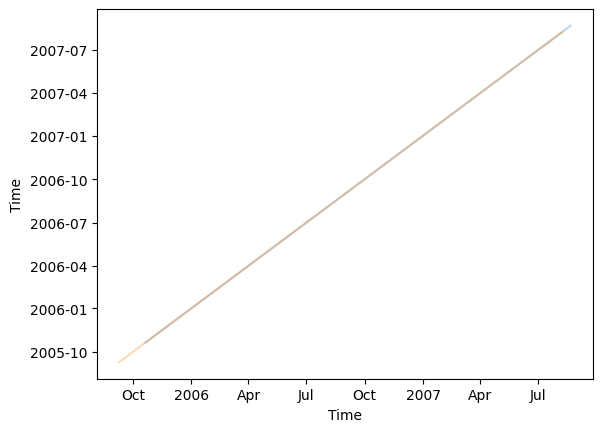

In [10]:
# Observing the Dataset
ds_anacapa1 = xr.open_dataset(ts_files[0], decode_times=True)
ds_anacapa2 = xr.open_dataset(ts_files[1], decode_times=True)
print(ds_anacapa1.ID.data, ds_anacapa2.ID.data)

print(ds_anacapa1.TIME.data[:10])
print(ds_anacapa2.TIME.data[:10])

print(ds_anacapa1.TIME.plot(alpha=0.3))
print(ds_anacapa2.TIME.plot(alpha=0.3))

In [11]:
# Read Datasets, don't decode times
ds_anacapa1 = xr.open_dataset(ts_files[0], decode_times=False)
ds_anacapa2 = xr.open_dataset(ts_files[1], decode_times=False)

In [12]:
print("All time values at station 'Black Sea Bass Reef' subtracted by two minutes: ", "\n",
      cftime.num2date(times = ds_anacapa1.TIME.data - 120,
                units = "seconds since 1970-01-01T00:00:00Z"))

# Round the time values of Black Sea Bass Reef to match the time values of East Fish Camp
ds_anacapa1.TIME.data[:] = ds_anacapa1.TIME.data[:] - 120

All time values at station 'Black Sea Bass Reef' subtracted by two minutes:  
 [cftime.DatetimeGregorian(2005, 10, 20, 17, 30, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2005, 10, 20, 18, 30, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2005, 10, 20, 19, 30, 0, 0, has_year_zero=False)
 ...
 cftime.DatetimeGregorian(2007, 8, 20, 22, 40, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2007, 8, 20, 23, 40, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2007, 8, 21, 0, 40, 0, 0, has_year_zero=False)]


In [13]:
# Find common time values of both time series
time = np.intersect1d(ds_anacapa1.TIME.data, ds_anacapa2.TIME.data)
print("Number of common time values in both time series: ", len(time))

Number of common time values in both time series:  5568


In [14]:
# Subset both datasets by common time coordinates
ds_anacapa1 = ds_anacapa1.sel(TIME = time)
ds_anacapa2 = ds_anacapa2.sel(TIME = time)

print("Dimension of two datasets with common time coordinates: ", "\n",
      ds_anacapa1.dims, "\n", ds_anacapa2.dims)

Dimension of two datasets with common time coordinates:  
 FrozenMappingWarningOnValuesAccess({'LON': 1, 'LAT': 1, 'DEPTH': 1, 'TIME': 5568}) 
 FrozenMappingWarningOnValuesAccess({'LON': 1, 'LAT': 1, 'DEPTH': 1, 'TIME': 5568})


In [15]:
# Longitudes of two stations
lon = [ds_anacapa1.LON.data[0], ds_anacapa2.LON.data[0]]
print("Longitudes of two stations: ", lon)

# Latitudes of two stations
lat = [ds_anacapa1.LAT.data[0], ds_anacapa2.LAT.data[0]]
print("Latitudes of two stations: ", lat)

# Depth of two stations
depth = [ds_anacapa1.DEPTH.data[0], ds_anacapa2.DEPTH.data[0]]
print("Depth of two stations: ", depth)

# Names of two stations
station_name = [ds_anacapa1.ID.data.astype("str").item(),
                ds_anacapa2.ID.data.astype("str").item()]
print("Names of two stations: ", station_name)

Longitudes of two stations:  [-119.38333, -119.38333]
Latitudes of two stations:  [34.0, 34.0]
Depth of two stations:  [17, 11]
Names of two stations:  ['Anacapa (Black Sea Bass Reef)', 'Anacapa (East Fish Camp)']


In [16]:
# Extract data of Temperature values;
# it should be composed as a 2D array of dimension (station, time); in this example of dimension (2, 5568)
temp = np.row_stack((ds_anacapa1.Temperature.data.reshape([len(ds_anacapa1.Temperature.data)]),
                    ds_anacapa2.Temperature.data.reshape([len(ds_anacapa2.Temperature.data)])))
temp

array([[16.66, 16.5 , 16.5 , ..., 13.21, 12.74, 12.74],
       [14.99, 14.21, 13.59, ..., 17.2 , 17.2 , 17.2 ]], dtype=float32)

In [17]:
# Extract Variable Attributes
attr_lat = ds_anacapa1.LAT.attrs
attr_lon = ds_anacapa1.LON.attrs
attr_depth = ds_anacapa1.DEPTH.attrs
attr_time = ds_anacapa1.TIME.attrs
attr_temp = ds_anacapa1.Temperature.attrs

In [18]:
ds_anacapa = xr.Dataset(
    coords = {
        "time": (["time"], time, attr_time),
        "lat": (["station"], lat, attr_lat),
        "lon": (["station"], lon, attr_lon),
        "depth": (["station"], depth, attr_depth),
        "station_name": (["station"], station_name, {"long_name": "station name",
                                                     "cf_role": "timeseries_id"})
    },
    data_vars = {
        "temperature": (["station", "time"], temp, attr_temp)
    }
)
ds_anacapa

<xarray.Dataset> Size: 89kB
Dimensions:       (station: 2, time: 5568)
Coordinates:
  * time          (time) float64 45kB 1.13e+09 1.13e+09 ... 1.15e+09 1.15e+09
    lat           (station) float32 8B 34.0 34.0
    lon           (station) float32 8B -119.4 -119.4
    depth         (station) int32 8B 17 11
    station_name  (station) <U29 232B 'Anacapa (Black Sea Bass Reef)' 'Anacap...
Dimensions without coordinates: station
Data variables:
    temperature   (station, time) float32 45kB 16.66 16.5 16.5 ... 17.2 17.2

In [19]:
# Add additional variable attributes
ds_anacapa.temperature.attrs['coordinates'] = "lat lon depth station_name"

# Update Specific Variable Attributes
range_lon = [ds_anacapa.lon.data.min(), ds_anacapa.lon.data.max()]
range_lat = [ds_anacapa.lat.data.min(), ds_anacapa.lat.data.max()]
range_depth = [ds_anacapa.depth.data.min(), ds_anacapa.depth.data.max()]
range_time = [ds_anacapa.time.data.min(), ds_anacapa.time.data.max()]
range_temp = [ds_anacapa.temperature.data.min(), ds_anacapa.temperature.data.max()]

ds_anacapa.lon.attrs['actual_range'] = range_lon
ds_anacapa.lat.attrs['actual_range'] = range_lat
ds_anacapa.depth.attrs['actual_range'] = range_depth
ds_anacapa.time.attrs['actual_range'] = range_time
ds_anacapa.temperature.attrs['actual_range'] = range_temp

# Add Global Attribute
ds_anacapa.attrs['featureType'] = "timeSeries"

In [20]:
ds_anacapa.info()

xarray.Dataset {
dimensions:
	station = 2 ;
	time = 5568 ;

variables:
	float32 temperature(station, time) ;
		temperature:actual_range = [10.65, 18.48] ;
		temperature:long_name = Sea Temperature ;
		temperature:standard_name = sea_water_temperature ;
		temperature:units = degree_C ;
		temperature:coordinates = lat lon depth station_name ;
	float64 time(time) ;
		time:_CoordinateAxisType = Time ;
		time:actual_range = [1129829400.0, 1149870600.0] ;
		time:axis = T ;
		time:long_name = Time ;
		time:standard_name = time ;
		time:time_origin = 01-JAN-1970 00:00:00 ;
		time:units = seconds since 1970-01-01T00:00:00Z ;
	float32 lat(station) ;
		lat:_CoordinateAxisType = Lat ;
		lat:actual_range = [34.0, 34.0] ;
		lat:axis = Y ;
		lat:long_name = Latitude ;
		lat:standard_name = latitude ;
		lat:units = degrees_north ;
	float32 lon(station) ;
		lon:_CoordinateAxisType = Lon ;
		lon:actual_range = [-119.38333, -119.38333] ;
		lon:axis = X ;
		lon:long_name = Longitude ;
		lon:standard_name 

## 3. Incomplete multidimensional array representation of time series (H.2.2)

Multiple stations, time series of same length but have different time values

Technically, it's also possible to use this template for time series with different length. You can refer to another [exercise](https://gitlab.rrz.uni-hamburg.de/BAO4478/workshop_2024_how_to_create_publishable_netcdf_data/-/blob/main/exercises/multiple_time_series_different_time_values.ipynb?ref_type=heads) in the Gitlab repository for this case.

In [21]:
ds_anacapa1 = xr.open_dataset(ts_files[0], decode_times=False)
ds_anacapa2 = xr.open_dataset(ts_files[1], decode_times=False)
print(ds_anacapa1.ID.data, ds_anacapa2.ID.data)

ds_anacapa2

b'Anacapa (Black Sea Bass Reef)' b'Anacapa (East Fish Camp)'


<xarray.Dataset> Size: 201kB
Dimensions:      (LON: 1, LAT: 1, DEPTH: 1, TIME: 16733)
Coordinates:
  * LON          (LON) float32 4B -119.4
  * LAT          (LAT) float32 4B 34.0
  * DEPTH        (DEPTH) int32 4B 11
  * TIME         (TIME) float64 134kB 1.126e+09 1.126e+09 ... 1.187e+09
Data variables:
    Temperature  (TIME, DEPTH, LAT, LON) float32 67kB ...
    ID           |S24 24B b'Anacapa (East Fish Camp)'
Attributes: (12/38)
    acknowledgement:               NOAA NESDIS COASTWATCH, NOAA SWFSC ERD
    cdm_data_type:                 Station
    contributor_name:              Channel Islands National Park, National Pa...
    contributor_role:              Source of data.
    Conventions:                   COARDS, CF-1.0, Unidata Observation Datase...
    creator_email:                 Roy.Mendelssohn@noaa.gov
    ...                            ...
    standard_name_vocabulary:      CF-1.0
    summary:                       The subtidal temperature data taken at Cha...
    time_coverage_end:             2007-08-07T21:38:00Z
    time_coverage_start:           2005-09-09T18:30:00Z
    title:                         Sea Temperature (Kelp Forest Monitoring, C...
    Westernmost_Easting:           -119.38333

In [22]:
# Subset both datasets to be same length / Select same amount of observation from both datasets
ds_anacapa1 = ds_anacapa1.isel(TIME = slice(None, 50))
ds_anacapa2 = ds_anacapa2.isel(TIME = slice(-50, None))

print("Dimensions of the data subset 1: ", ds_anacapa1.dims)
print("Dimensions of the data subset 2: ", ds_anacapa2.dims)

Dimensions of the data subset 1:  FrozenMappingWarningOnValuesAccess({'LON': 1, 'LAT': 1, 'DEPTH': 1, 'TIME': 50})
Dimensions of the data subset 2:  FrozenMappingWarningOnValuesAccess({'LON': 1, 'LAT': 1, 'DEPTH': 1, 'TIME': 50})


In [23]:
# Longitudes of two stations
lon = [ds_anacapa1.LON.data[0], ds_anacapa2.LON.data[0]]
print("Longitudes of two stations: ", lon)

# Latitudes of two stations
lat = [ds_anacapa1.LAT.data[0], ds_anacapa2.LAT.data[0]]
print("Latitudes of two stations: ", lat)

# Depth of two stations
depth = [ds_anacapa1.DEPTH.data[0], ds_anacapa2.DEPTH.data[0]]
print("Depth of two stations: ", depth)

# Names of two stations
station_name = [ds_anacapa1.ID.data.astype("str").item(),
                ds_anacapa2.ID.data.astype("str").item()]
print("Names of two stations: ", station_name)

Longitudes of two stations:  [-119.38333, -119.38333]
Latitudes of two stations:  [34.0, 34.0]
Depth of two stations:  [17, 11]
Names of two stations:  ['Anacapa (Black Sea Bass Reef)', 'Anacapa (East Fish Camp)']


In [24]:
# "time" is a two-dimensional array of (station, obs), in this case (2, 50)
# Create a 2D array from two 1D arrays
time = np.row_stack((ds_anacapa1.TIME.data, ds_anacapa2.TIME.data))

print(time)
print("Array shape of the time coordinates:", time.shape)

[[1.12982952e+09 1.12983312e+09 1.12983672e+09 1.12984032e+09
  1.12984392e+09 1.12984752e+09 1.12985112e+09 1.12985472e+09
  1.12985832e+09 1.12986192e+09 1.12986552e+09 1.12986912e+09
  1.12987272e+09 1.12987632e+09 1.12987992e+09 1.12988352e+09
  1.12988712e+09 1.12989072e+09 1.12989432e+09 1.12989792e+09
  1.12990152e+09 1.12990512e+09 1.12990872e+09 1.12991232e+09
  1.12991592e+09 1.12991952e+09 1.12992312e+09 1.12992672e+09
  1.12993032e+09 1.12993392e+09 1.12993752e+09 1.12994112e+09
  1.12994472e+09 1.12994832e+09 1.12995192e+09 1.12995552e+09
  1.12995912e+09 1.12996272e+09 1.12996632e+09 1.12996992e+09
  1.12997352e+09 1.12997712e+09 1.12998072e+09 1.12998432e+09
  1.12998792e+09 1.12999152e+09 1.12999512e+09 1.12999872e+09
  1.13000232e+09 1.13000592e+09]
 [1.18634628e+09 1.18634988e+09 1.18635348e+09 1.18635708e+09
  1.18636068e+09 1.18636428e+09 1.18636788e+09 1.18637148e+09
  1.18637508e+09 1.18637868e+09 1.18638228e+09 1.18638588e+09
  1.18638948e+09 1.18639308e+09 1.186

In [25]:
# Data Variable "Temperature" will be a 2D array of shape (station, obs), in this example (2, 50)
temp = np.row_stack((ds_anacapa1.Temperature.data.reshape([len(ds_anacapa1.Temperature)]),
                     ds_anacapa2.Temperature.data.reshape([len(ds_anacapa2.Temperature)])))
print("Array shape of the temperature variable: ", temp.shape)

Array shape of the temperature variable:  (2, 50)


In [26]:
# Extract Variable Attributes
attr_lat = ds_anacapa1.LAT.attrs
attr_lon = ds_anacapa1.LON.attrs
attr_depth = ds_anacapa1.DEPTH.attrs
attr_time = ds_anacapa1.TIME.attrs
attr_temp = ds_anacapa1.Temperature.attrs

In [27]:
# Restructure the data
ds_anacapa = xr.Dataset(
    coords = {
        "lat": (["station"], lat, attr_lat),
        "lon": (["station"], lon, attr_lon),
        "depth": (["station"], depth, attr_depth),
        "station_name": (["station"], station_name, {"long_name":"station name",
                                                     "cf_role": "timeseries_id"}),
        "time": (["station","obs"], time, attr_time)
    },
    data_vars = {
        "temperature": (["station","obs"], temp, attr_temp)
    }
)

ds_anacapa

<xarray.Dataset> Size: 1kB
Dimensions:       (station: 2, obs: 50)
Coordinates:
    lat           (station) float32 8B 34.0 34.0
    lon           (station) float32 8B -119.4 -119.4
    depth         (station) int32 8B 17 11
    station_name  (station) <U29 232B 'Anacapa (Black Sea Bass Reef)' 'Anacap...
    time          (station, obs) float64 800B 1.13e+09 1.13e+09 ... 1.187e+09
Dimensions without coordinates: station, obs
Data variables:
    temperature   (station, obs) float32 400B 16.66 16.5 16.5 ... 18.09 18.74

In [28]:
# Add Additional Variable Attributes
ds_anacapa.time.attrs['coordinates'] = "time lat lon depth station_name"

# Update Specific Variable Attributes
range_lon = [ds_anacapa.lon.data.min(), ds_anacapa.lon.data.max()]
range_lat = [ds_anacapa.lat.data.min(), ds_anacapa.lat.data.max()]
range_depth = [ds_anacapa.depth.data.min(), ds_anacapa.depth.data.max()]
range_time = [ds_anacapa.time.data.min(), ds_anacapa.time.data.max()]
range_temp = [ds_anacapa.temperature.data.min(), ds_anacapa.temperature.data.max()]

ds_anacapa.lon.attrs['actual_range'] = range_lon
ds_anacapa.lat.attrs['actual_range'] = range_lat
ds_anacapa.depth.attrs['actual_range'] = range_depth
ds_anacapa.time.attrs['actual_range'] = range_time
ds_anacapa.temperature.attrs['actual_range'] = range_temp

# Add Global Attribute
ds_anacapa.attrs['featureType'] = "timeSeries"

In [29]:
ds_anacapa.info()

xarray.Dataset {
dimensions:
	station = 2 ;
	obs = 50 ;

variables:
	float32 temperature(station, obs) ;
		temperature:actual_range = [14.75, 20.21] ;
		temperature:long_name = Sea Temperature ;
		temperature:standard_name = sea_water_temperature ;
		temperature:units = degree_C ;
	float32 lat(station) ;
		lat:_CoordinateAxisType = Lat ;
		lat:actual_range = [34.0, 34.0] ;
		lat:axis = Y ;
		lat:long_name = Latitude ;
		lat:standard_name = latitude ;
		lat:units = degrees_north ;
	float32 lon(station) ;
		lon:_CoordinateAxisType = Lon ;
		lon:actual_range = [-119.38333, -119.38333] ;
		lon:axis = X ;
		lon:long_name = Longitude ;
		lon:standard_name = longitude ;
		lon:units = degrees_east ;
	int32 depth(station) ;
		depth:_CoordinateAxisType = Height ;
		depth:_CoordinateZisPositive = down ;
		depth:actual_range = [11, 17] ;
		depth:axis = Z ;
		depth:long_name = Depth ;
		depth:positive = down ;
		depth:standard_name = depth ;
		depth:units = m ;
	<U29 station_name(station) ;
		stati

In [30]:
ds_anacapa.time

<xarray.DataArray 'time' (station: 2, obs: 50)> Size: 800B
array([[1.12982952e+09, 1.12983312e+09, 1.12983672e+09, 1.12984032e+09,
        1.12984392e+09, 1.12984752e+09, 1.12985112e+09, 1.12985472e+09,
        1.12985832e+09, 1.12986192e+09, 1.12986552e+09, 1.12986912e+09,
        1.12987272e+09, 1.12987632e+09, 1.12987992e+09, 1.12988352e+09,
        1.12988712e+09, 1.12989072e+09, 1.12989432e+09, 1.12989792e+09,
        1.12990152e+09, 1.12990512e+09, 1.12990872e+09, 1.12991232e+09,
        1.12991592e+09, 1.12991952e+09, 1.12992312e+09, 1.12992672e+09,
        1.12993032e+09, 1.12993392e+09, 1.12993752e+09, 1.12994112e+09,
        1.12994472e+09, 1.12994832e+09, 1.12995192e+09, 1.12995552e+09,
        1.12995912e+09, 1.12996272e+09, 1.12996632e+09, 1.12996992e+09,
        1.12997352e+09, 1.12997712e+09, 1.12998072e+09, 1.12998432e+09,
        1.12998792e+09, 1.12999152e+09, 1.12999512e+09, 1.12999872e+09,
        1.13000232e+09, 1.13000592e+09],
       [1.18634628e+09, 1.18634988e+09, 1.18635348e+09, 1.18635708e+09,
        1.18636068e+09, 1.18636428e+09, 1.18636788e+09, 1.18637148e+09,
        1.18637508e+09, 1.18637868e+09, 1.18638228e+09, 1.18638588e+09,
        1.18638948e+09, 1.18639308e+09, 1.18639668e+09, 1.18640028e+09,
        1.18640388e+09, 1.18640748e+09, 1.18641108e+09, 1.18641468e+09,
        1.18641828e+09, 1.18642188e+09, 1.18642548e+09, 1.18642908e+09,
        1.18643268e+09, 1.18643628e+09, 1.18643988e+09, 1.18644348e+09,
        1.18644708e+09, 1.18645068e+09, 1.18645428e+09, 1.18645788e+09,
        1.18646148e+09, 1.18646508e+09, 1.18646868e+09, 1.18647228e+09,
        1.18647588e+09, 1.18647948e+09, 1.18648308e+09, 1.18648668e+09,
        1.18649028e+09, 1.18649388e+09, 1.18649748e+09, 1.18650108e+09,
        1.18650468e+09, 1.18650828e+09, 1.18651188e+09, 1.18651548e+09,
        1.18651908e+09, 1.18652268e+09]])
Coordinates:
    lat           (station) float32 8B 34.0 34.0
    lon           (station) float32 8B -119.4 -119.4
    depth         (station) int32 8B 17 11
    station_name  (station) <U29 232B 'Anacapa (Black Sea Bass Reef)' 'Anacap...
    time          (station, obs) float64 800B 1.13e+09 1.13e+09 ... 1.187e+09
Dimensions without coordinates: station, obs
Attributes:
    _CoordinateAxisType:  Time
    actual_range:         [1129829520.0, 1186522680.0]
    axis:                 T
    long_name:            Time
    standard_name:        time
    time_origin:          01-JAN-1970 00:00:00
    units:                seconds since 1970-01-01T00:00:00Z
    coordinates:          time lat lon depth station_name

## 4. Contiguous ragged array representation of time series (H.2.4)

In [31]:
ds_anacapa1 = xr.open_dataset(ts_files[0], decode_times=False)
ds_anacapa2 = xr.open_dataset(ts_files[1], decode_times=False)
print(ds_anacapa1.ID.data, ds_anacapa2.ID.data)

b'Anacapa (Black Sea Bass Reef)' b'Anacapa (East Fish Camp)'


In [32]:
# Longitudes of two stations
lon = [ds_anacapa1.LON.data[0], ds_anacapa2.LON.data[0]]
print("Longitudes of two stations: ", lon)

# Latitudes of two stations
lat = [ds_anacapa1.LAT.data[0], ds_anacapa2.LAT.data[0]]
print("Latitudes of two stations: ", lat)

# Depth of two stations
depth = [ds_anacapa1.DEPTH.data[0], ds_anacapa2.DEPTH.data[0]]
print("Depth of two stations: ", depth)

# Names of two stations
station_name = [ds_anacapa1.ID.data.astype("str").item(),
                ds_anacapa2.ID.data.astype("str").item()]
print("Names of two stations: ", station_name)

# Number of observations for each station
row_size = [len(ds_anacapa1.TIME), len(ds_anacapa2.TIME)]
print("Number of observations for each station: ", row_size)

Longitudes of two stations:  [-119.38333, -119.38333]
Latitudes of two stations:  [34.0, 34.0]
Depth of two stations:  [17, 11]
Names of two stations:  ['Anacapa (Black Sea Bass Reef)', 'Anacapa (East Fish Camp)']
Number of observations for each station:  [16065, 16733]


In [33]:
# Time coordinates of all observations at two stations
time = np.concatenate([ds_anacapa1.TIME.data, ds_anacapa2.TIME.data])
print("Array shape of the time coordinates:", time.shape)

Array shape of the time coordinates: (32798,)


In [34]:
# Merge the temperature of all observations at two stations to 1D-array.
temp = np.concatenate([ds_anacapa1.Temperature.data.reshape(len(ds_anacapa1.TIME)),
                       ds_anacapa2.Temperature.data.reshape(len(ds_anacapa2.TIME))])
print("Array shape of the temperature variable for two stations:", temp.shape)

Array shape of the temperature variable for two stations: (32798,)


In [35]:
# Extract Variable Attributes
attr_lat = ds_anacapa1.LAT.attrs
attr_lon = ds_anacapa1.LON.attrs
attr_depth = ds_anacapa1.DEPTH.attrs
attr_time = ds_anacapa1.TIME.attrs
attr_temp = ds_anacapa1.Temperature.attrs

In [36]:
# Compose the new Dataset
ds_anacapa = xr.Dataset(
    coords = {
        'lon': (['station'], np.float32(lon), attr_lon),
        'lat': (['station'], np.float32(lat), attr_lat),
        'depth': (['station'], np.float32(depth), attr_depth),
        'time': (['obs'], np.float64(time), attr_time),
        'station_name': (['station'], station_name)
    },
    data_vars = {'temperature': (['obs'], np.float32(temp), attr_temp),
                 'row_size': (['station'], np.int32(row_size))}
)

ds_anacapa

<xarray.Dataset> Size: 394kB
Dimensions:       (obs: 32798, station: 2)
Coordinates:
    lon           (station) float32 8B -119.4 -119.4
    lat           (station) float32 8B 34.0 34.0
    depth         (station) float32 8B 17.0 11.0
    time          (obs) float64 262kB 1.13e+09 1.13e+09 ... 1.187e+09 1.187e+09
    station_name  (station) <U29 232B 'Anacapa (Black Sea Bass Reef)' 'Anacap...
Dimensions without coordinates: obs, station
Data variables:
    temperature   (obs) float32 131kB 16.66 16.5 16.5 ... 16.81 18.09 18.74
    row_size      (station) int32 8B 16065 16733

In [37]:
# Add some more variable attributes
ds_anacapa.station_name.attrs = {"long_name": "station name",
                                 "cf_role": "timeseries_id"}

ds_anacapa.row_size.attrs = {"long_name": "number of observations for this station",
                             "sample_dimension": "obs"}

In [38]:
# Add Global Attributes
ds_anacapa.attrs = {"featureType": "timeSeries"}

In [39]:
ds_anacapa.info()

xarray.Dataset {
dimensions:
	obs = 32798 ;
	station = 2 ;

variables:
	float32 temperature(obs) ;
		temperature:actual_range = [10.91 22.34] ;
		temperature:long_name = Sea Temperature ;
		temperature:standard_name = sea_water_temperature ;
		temperature:units = degree_C ;
	int32 row_size(station) ;
		row_size:long_name = number of observations for this station ;
		row_size:sample_dimension = obs ;
	float32 lon(station) ;
		lon:_CoordinateAxisType = Lon ;
		lon:actual_range = [-119.38333 -119.38333] ;
		lon:axis = X ;
		lon:long_name = Longitude ;
		lon:standard_name = longitude ;
		lon:units = degrees_east ;
	float32 lat(station) ;
		lat:_CoordinateAxisType = Lat ;
		lat:actual_range = [34. 34.] ;
		lat:axis = Y ;
		lat:long_name = Latitude ;
		lat:standard_name = latitude ;
		lat:units = degrees_north ;
	float32 depth(station) ;
		depth:_CoordinateAxisType = Height ;
		depth:_CoordinateZisPositive = down ;
		depth:actual_range = [17 17] ;
		depth:axis = Z ;
		depth:long_name = Depth

In [40]:
# Update Variable Attribute: actual_range...
range_lon = [ds_anacapa.lon.data.min(), ds_anacapa.lon.data.max()]
range_lat = [ds_anacapa.lat.data.min(), ds_anacapa.lat.data.max()]
range_depth = [ds_anacapa.depth.data.min(), ds_anacapa.depth.data.max()]
range_time = [ds_anacapa.time.data.min(), ds_anacapa.time.data.max()]
range_temp = [ds_anacapa.temperature.data.min(), ds_anacapa.temperature.data.max()]

ds_anacapa.lon.attrs['actual_range'] = range_lon
ds_anacapa.lat.attrs['actual_range'] = range_lat
ds_anacapa.depth.attrs['actual_range'] = range_depth
ds_anacapa.time.attrs['actual_range'] = range_time
ds_anacapa.temperature.attrs['actual_range'] = range_temp

ds_anacapa.info()

xarray.Dataset {
dimensions:
	obs = 32798 ;
	station = 2 ;

variables:
	float32 temperature(obs) ;
		temperature:actual_range = [10.4, 23.07] ;
		temperature:long_name = Sea Temperature ;
		temperature:standard_name = sea_water_temperature ;
		temperature:units = degree_C ;
	int32 row_size(station) ;
		row_size:long_name = number of observations for this station ;
		row_size:sample_dimension = obs ;
	float32 lon(station) ;
		lon:_CoordinateAxisType = Lon ;
		lon:actual_range = [-119.38333, -119.38333] ;
		lon:axis = X ;
		lon:long_name = Longitude ;
		lon:standard_name = longitude ;
		lon:units = degrees_east ;
	float32 lat(station) ;
		lat:_CoordinateAxisType = Lat ;
		lat:actual_range = [34.0, 34.0] ;
		lat:axis = Y ;
		lat:long_name = Latitude ;
		lat:standard_name = latitude ;
		lat:units = degrees_north ;
	float32 depth(station) ;
		depth:_CoordinateAxisType = Height ;
		depth:_CoordinateZisPositive = down ;
		depth:actual_range = [11.0, 17.0] ;
		depth:axis = Z ;
		depth:long_nam

## 5. Indexed ragged array representation of time series (H.2.5)

When time series with different lengths are written incrementally.

In [41]:
ds_anacapa1 = xr.open_dataset(ts_files[0], decode_times=False)
ds_anacapa2 = xr.open_dataset(ts_files[1], decode_times=False)
print(ds_anacapa1.ID.data, ds_anacapa2.ID.data)

b'Anacapa (Black Sea Bass Reef)' b'Anacapa (East Fish Camp)'


In [42]:
# Longitudes of two stations
lon = [ds_anacapa1.LON.data[0], ds_anacapa2.LON.data[0]]
print("Longitudes of two stations: ", lon)

# Latitudes of two stations
lat = [ds_anacapa1.LAT.data[0], ds_anacapa2.LAT.data[0]]
print("Latitudes of two stations: ", lat)

# Depth of two stations
depth = [ds_anacapa1.DEPTH.data[0], ds_anacapa2.DEPTH.data[0]]
print("Depth of two stations: ", depth)

# Names of two stations
station_name = [ds_anacapa1.ID.data.astype("str").item(),
                ds_anacapa2.ID.data.astype("str").item()]
print("Names of two stations: ", station_name)

# Create an index for each station
index = list(range(len(station_name)))
print("Index of stations: ", index)

Longitudes of two stations:  [-119.38333, -119.38333]
Latitudes of two stations:  [34.0, 34.0]
Depth of two stations:  [17, 11]
Names of two stations:  ['Anacapa (Black Sea Bass Reef)', 'Anacapa (East Fish Camp)']
Index of stations:  [0, 1]


In [43]:
# Time coordinates of all observations at two stations
time = np.concatenate([ds_anacapa1.TIME.data, ds_anacapa2.TIME.data])
print("Array shape of the time coordinates:", time.shape)

Array shape of the time coordinates: (32798,)


In [44]:
# Temperature of all observations at two stations
temp = np.concatenate([ds_anacapa1.Temperature.data.reshape(len(ds_anacapa1.TIME)),
                       ds_anacapa2.Temperature.data.reshape(len(ds_anacapa2.TIME))])
print("Array shape of the temperature variable for two stations:", temp.shape)

Array shape of the temperature variable for two stations: (32798,)


In [45]:
# Assign an index to each station
stationIndex = np.concatenate([np.tile(index[0], len(ds_anacapa1.TIME)),
                               np.tile(index[1], len(ds_anacapa2.TIME))])
print("Station Index of all existing observations: ", stationIndex)
print("Array shape of the staion index: ", stationIndex.shape)

Station Index of all existing observations:  [0 0 0 ... 1 1 1]
Array shape of the staion index:  (32798,)


In [46]:
# Extract Variable Attributes
attr_lat = ds_anacapa1.LAT.attrs
attr_lon = ds_anacapa1.LON.attrs
attr_depth = ds_anacapa1.DEPTH.attrs
attr_time = ds_anacapa1.TIME.attrs
attr_temp = ds_anacapa1.Temperature.attrs

In [47]:
# Compose the new Dataset
ds_anacapa = xr.Dataset(
    coords = {
        'lon': (['station'], np.float32(lon), attr_lon),
        'lat': (['station'], np.float32(lat), attr_lat),
        'depth': (['station'], np.float32(depth), attr_depth),
        'time': (['obs'], np.float64(time), attr_time),
        'station_name': (['station'], station_name, {"long_name": "station name",
                                                     "cf_role":"timeseries_id"}),

        # Assign each station with an index
        'station_info': (['station'], np.byte(index), {"long_name":"0-Anacapa, 1-SanClemente"}),
        'stationIndex': (['obs'], np.byte(stationIndex), {"long_name":"which station this obs is for",
                                                          "instance_dimension": "station"})
    },
    data_vars = {'temperature': (['obs'], np.float32(temp), attr_temp)}
)

ds_anacapa

<xarray.Dataset> Size: 427kB
Dimensions:       (obs: 32798, station: 2)
Coordinates:
    lon           (station) float32 8B -119.4 -119.4
    lat           (station) float32 8B 34.0 34.0
    depth         (station) float32 8B 17.0 11.0
    time          (obs) float64 262kB 1.13e+09 1.13e+09 ... 1.187e+09 1.187e+09
    station_name  (station) <U29 232B 'Anacapa (Black Sea Bass Reef)' 'Anacap...
    station_info  (station) int8 2B 0 1
    stationIndex  (obs) int8 33kB 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
Dimensions without coordinates: obs, station
Data variables:
    temperature   (obs) float32 131kB 16.66 16.5 16.5 ... 16.81 18.09 18.74

In [48]:
# Add Global Attributes
ds_anacapa.attrs['featureType'] = "timeSeries"

# Update Variable Attribute: actual_range...
range_lon = [ds_anacapa.lon.data.min(), ds_anacapa.lon.data.max()]
range_lat = [ds_anacapa.lat.data.min(), ds_anacapa.lat.data.max()]
range_depth = [ds_anacapa.depth.data.min(), ds_anacapa.depth.data.max()]
range_time = [ds_anacapa.time.data.min(), ds_anacapa.time.data.max()]
range_temp = [ds_anacapa.temperature.data.min(), ds_anacapa.temperature.data.max()]

ds_anacapa.lon.attrs['actual_range'] = range_lon
ds_anacapa.lat.attrs['actual_range'] = range_lat
ds_anacapa.depth.attrs['actual_range'] = range_depth
ds_anacapa.time.attrs['actual_range'] = range_time
ds_anacapa.temperature.attrs['actual_range'] = range_temp

In [49]:
ds_anacapa.info()

xarray.Dataset {
dimensions:
	obs = 32798 ;
	station = 2 ;

variables:
	float32 temperature(obs) ;
		temperature:actual_range = [10.4, 23.07] ;
		temperature:long_name = Sea Temperature ;
		temperature:standard_name = sea_water_temperature ;
		temperature:units = degree_C ;
	float32 lon(station) ;
		lon:_CoordinateAxisType = Lon ;
		lon:actual_range = [-119.38333, -119.38333] ;
		lon:axis = X ;
		lon:long_name = Longitude ;
		lon:standard_name = longitude ;
		lon:units = degrees_east ;
	float32 lat(station) ;
		lat:_CoordinateAxisType = Lat ;
		lat:actual_range = [34.0, 34.0] ;
		lat:axis = Y ;
		lat:long_name = Latitude ;
		lat:standard_name = latitude ;
		lat:units = degrees_north ;
	float32 depth(station) ;
		depth:_CoordinateAxisType = Height ;
		depth:_CoordinateZisPositive = down ;
		depth:actual_range = [11.0, 17.0] ;
		depth:axis = Z ;
		depth:long_name = Depth ;
		depth:positive = down ;
		depth:standard_name = depth ;
		depth:units = m ;
	float64 time(obs) ;
		time:_Coordinat

In [50]:
ds_anacapa.to_netcdf(path = os.path.join(os.getcwd(),"dsg_timeSeries","output_h25.nc"),
                     unlimited_dims=["obs"])

In [51]:
ds_test = xr.open_dataset(os.path.join(os.getcwd(),"dsg_timeSeries","output_h25.nc"))
ds_test

<xarray.Dataset> Size: 427kB
Dimensions:       (obs: 32798, station: 2)
Coordinates:
    lon           (station) float32 8B ...
    lat           (station) float32 8B ...
    depth         (station) float32 8B ...
    time          (obs) datetime64[ns] 262kB ...
    station_name  (station) <U29 232B ...
    station_info  (station) int8 2B ...
    stationIndex  (obs) int8 33kB ...
Dimensions without coordinates: obs, station
Data variables:
    temperature   (obs) float32 131kB ...
Attributes:
    featureType:  timeSeries

In [52]:
ds_test.info()

xarray.Dataset {
dimensions:
	obs = 32798 ;
	station = 2 ;

variables:
	float32 temperature(obs) ;
		temperature:actual_range = [10.4  23.07] ;
		temperature:long_name = Sea Temperature ;
		temperature:standard_name = sea_water_temperature ;
		temperature:units = degree_C ;
	float32 lon(station) ;
		lon:_CoordinateAxisType = Lon ;
		lon:actual_range = [-119.38333 -119.38333] ;
		lon:axis = X ;
		lon:long_name = Longitude ;
		lon:standard_name = longitude ;
		lon:units = degrees_east ;
	float32 lat(station) ;
		lat:_CoordinateAxisType = Lat ;
		lat:actual_range = [34. 34.] ;
		lat:axis = Y ;
		lat:long_name = Latitude ;
		lat:standard_name = latitude ;
		lat:units = degrees_north ;
	float32 depth(station) ;
		depth:_CoordinateAxisType = Height ;
		depth:_CoordinateZisPositive = down ;
		depth:actual_range = [11. 17.] ;
		depth:axis = Z ;
		depth:long_name = Depth ;
		depth:positive = down ;
		depth:standard_name = depth ;
		depth:units = m ;
	datetime64[ns] time(obs) ;
		time:_Coordinat